# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt

import sys
import time

sys.path.append("../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
epochs = 20
num_neurons = 128
onehot_dims = 4

# Load & Prepare the data

In [3]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_

In [4]:
all_data = pd.read_csv("./data_simplified/collected_sLI_tLO.csv", delimiter='\t')

all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLI_tRI.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)
all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLO_tLO.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)
all_data = pd.concat([all_data, pd.read_csv("./data_simplified/collected_sLO_tRI.csv", delimiter='\t')],
                     ignore_index=True).reset_index(drop=True)

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simplified_term").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

print(f"max redexes count: {max(all_data['redexes'])}")
print(f"min redexes count: {min(all_data['redexes'])}")

# make test/train split
x_train, x_test, y_train, y_test = train_test_split(all_data["simplified_term"].tolist(), all_data["redexes"].tolist(),
                                                    test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train)}")
print(f"Count testing samples: {len(y_test)}")

Count all terms: 9566

Count original terms: 7977

max redexes count: 170
min redexes count: 0
Count training samples: 6381
Count testing samples: 1596


In [6]:
bin_edges = [1, 4, 9, 14, 19, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 150]

y_train = np.digitize(y_train, bin_edges)
y_test = np.digitize(y_test, bin_edges)

# one-hot encode y-data
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [7]:
x_train = tokenize_and_vectorize(x_train)
x_test = tokenize_and_vectorize(x_test)

In [8]:
xy_train_data = list(zip(x_train, y_train))
xy_test_data = list(zip(x_test, y_test))

In [9]:
print(f"len(test_data) = {len(xy_test_data)}")
print(f"len(train_data) = {len(xy_train_data)}")

len(test_data) = 1596
len(train_data) = 6381


In [10]:
def train_generator():
    while True:
        random.shuffle(xy_train_data)
        for xtd, ytd in xy_train_data:
            yield np.array([xtd]), np.array([ytd])


def test_generator():
    while True:
        for xtd, ytd in xy_test_data:
            yield np.array([xtd]), np.array([ytd])

In [11]:
len(y_train[0])

17

# Define the model

In [12]:
model = Sequential()
model.add(LSTM(units=num_neurons,
               input_shape=(None, onehot_dims)))
model.add(Dense(units=17, activation='softmax'))

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense (Dense)               (None, 17)                2193      
                                                                 
Total params: 70289 (274.57 KB)
Trainable params: 70289 (274.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model_structure = model.to_json()
with open("./fine_models/v6_lstm_no_seq_reg_bins_cl.json", 'w') as json_file:
    json_file.write(model_structure)
# Define the ModelCheckpoint callback


In [15]:
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/v6_lstm_no_seq_reg_bins_cl.h5',  # Specify the path to save the best model
    monitor='accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [16]:
history = model.fit(train_generator(), steps_per_epoch=6381, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/20
6381/6381 [==============================] - 238s 37ms/step - loss: 1.5637 - accuracy: 0.3841
Epoch 2/20
   5/6381 [..............................] - ETA: 1:44 - loss: 1.2191 - accuracy: 0.6000

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6381/6381 [==============================] - 227s 36ms/step - loss: 1.1987 - accuracy: 0.5513
Epoch 3/20
6381/6381 [==============================] - 230s 36ms/step - loss: 0.9231 - accuracy: 0.6275
Epoch 4/20
6381/6381 [==============================] - 241s 38ms/step - loss: 1.0658 - accuracy: 0.5960
Epoch 5/20
6381/6381 [==============================] - 243s 38ms/step - loss: 1.4767 - accuracy: 0.4697
Epoch 6/20
6381/6381 [==============================] - 239s 37ms/step - loss: 1.4021 - accuracy: 0.5118
Epoch 7/20
6381/6381 [==============================] - 209s 33ms/step - loss: 1.3595 - accuracy: 0.5350
Epoch 8/20
6381/6381 [==============================] - 249s 39ms/step - loss: 1.3103 - accuracy: 0.5560
Epoch 9/20
6381/6381 [==============================] - 236s 37ms/step - loss: 1.1148 - accuracy: 0.6043
Epoch 10/20
6381/6381 [==============================] - 217s 34ms/step - loss: 0.7014 - accuracy: 0.7289
Epoch 11/20
6381/6381 [==============================] - 230s 36m

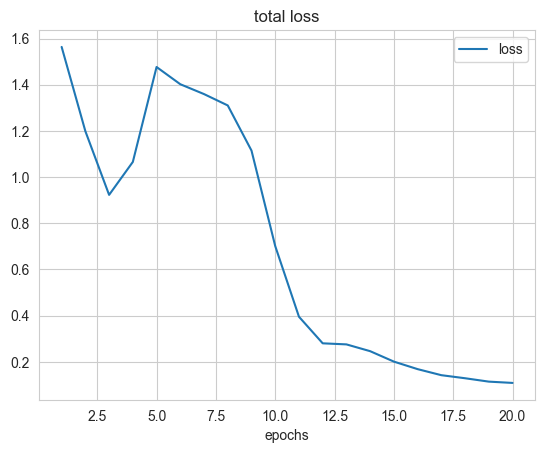

In [17]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

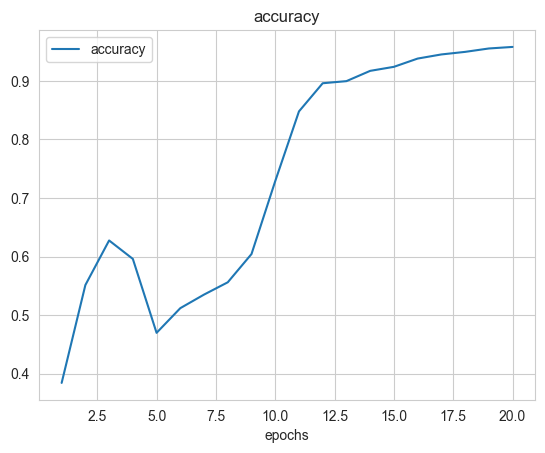

In [18]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [19]:
y_test_pred = []
for x_ in x_test:
    y_test_pred.append(model.predict(np.array([x_]), verbose=0)[0])

In [20]:
def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

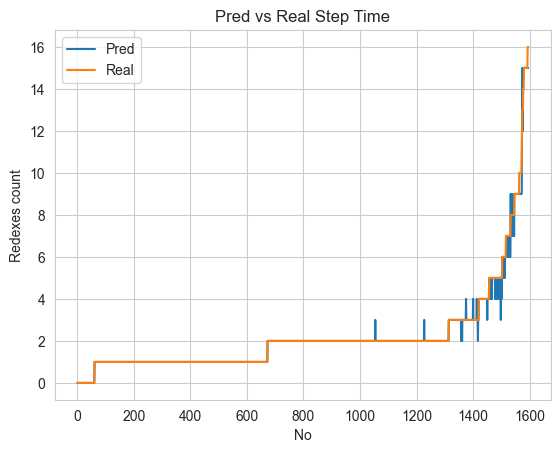

In [21]:
y_test_pred_nums = encoder.inverse_transform(np.array(y_test_pred))
y_test_nums = encoder.inverse_transform(y_test)

draw_pred_lines(y_test_pred_nums, y_test_nums)

In [22]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))

Test accuracy: 0.9611528822055138


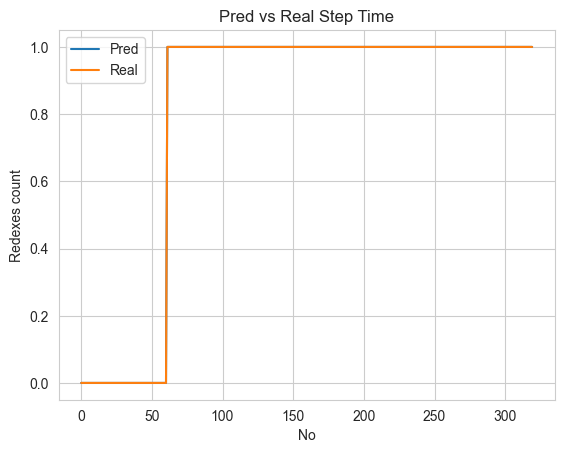

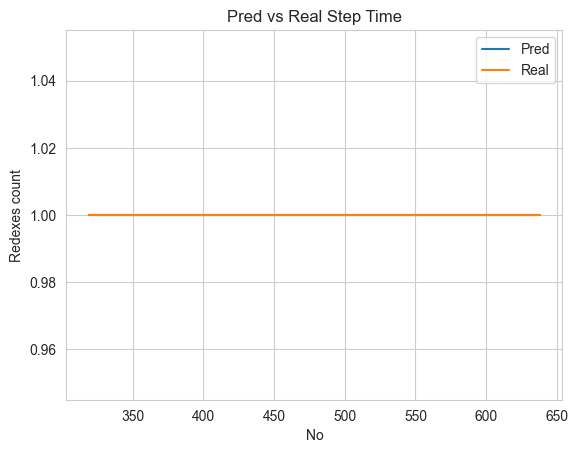

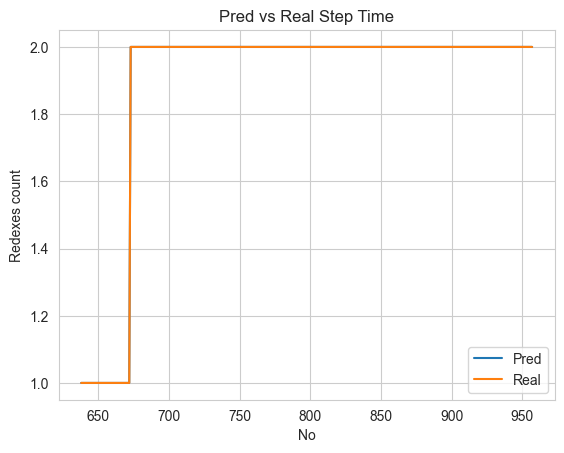

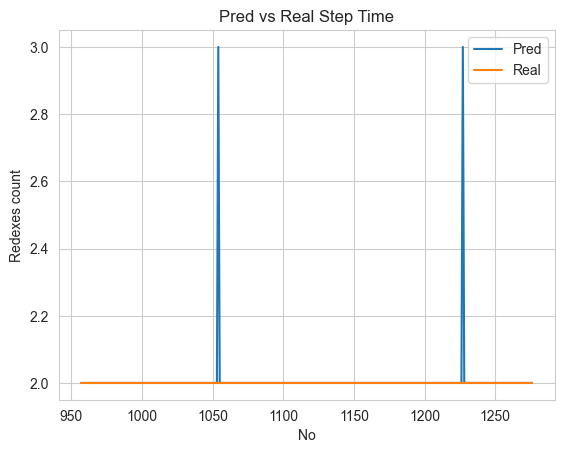

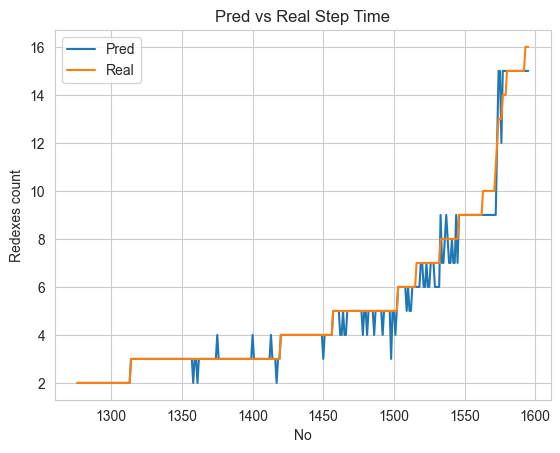

In [23]:
def draw_pred_lines_steps(y_pred, y_real, ranges):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    range_step = int(len(y_pred) / ranges)
    for range_no in range(ranges):
        for key_, val_ in drawing_df.items():
            plt.plot(range(range_no * range_step, ((range_no + 1) * range_step) + 1), val_[range_no * range_step : ((range_no + 1) * range_step) + 1], label=key_)

        plt.xlabel("No")
        plt.ylabel("Redexes count")
        plt.title("Pred vs Real Step Time")
        plt.legend()
        plt.show()


draw_pred_lines_steps(y_test_pred_nums, y_test_nums, 5)

In [26]:
def ite_term():
    x, y, c = Var(), Var(), Var()
    x_, y_, c_ = Atom(x), Atom(y), Atom(c)
    return Lambda(c, Lambda(x, Lambda(y, multi_app_term(c_, x_, y_))))


def true_term():
    x, y = Var(), Var()
    x_ = Atom(x)
    return Lambda(x, Lambda(y, x_))


def num_zero_term():
    s, z = Var(), Var()
    z_ = Atom(z)
    return Lambda(s, Lambda(z, z_))


def num_term(n: int):
    if n <= 0:
        return num_zero_term()
    s, z = Var(), Var()
    s_, z_ = Atom(s), Atom(z)
    core_term = App(s_, z_)
    for _ in range(n - 1):
        core_term = App(s_, core_term)
    return Lambda(s, Lambda(z, core_term))


def multi_app_term(term_0: Term, term_1: Term, *terms: Term):
    res_app_term = App(term_0, term_1)
    for term in terms:
        res_app_term = App(res_app_term, term)
    return res_app_term


def false_term():
    x, y = Var(), Var()
    y_ = Atom(y)
    return Lambda(x, Lambda(y, y_))


def pair_term():
    x, y, p = Var(), Var(), Var()
    x_, y_, p_ = Atom(x), Atom(y), Atom(p)
    return Lambda(x, Lambda(y, Lambda(p, multi_app_term(p_, x_, y_))))


def first_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, true_term()))


def second_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, false_term()))


def succ_term():
    x, y, n = Var(), Var(), Var()
    x_, y_, n_ = Atom(x), Atom(y), Atom(n)
    return Lambda(n, Lambda(x, Lambda(y, App(x_, multi_app_term(n_, x_, y_)))))


def sinc_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(
        p,
        multi_app_term(
            pair_term(),
            App(second_term(), p_),
            App(succ_term(), App(second_term(), p_)),
        ),
    )


def pred_term():
    n, f, x, g, h, u = Var(), Var(), Var(), Var(), Var(), Var()
    n_, f_, x_ = Atom(n), Atom(f), Atom(x)
    g_, h_, u_ = Atom(g), Atom(h), Atom(u)

    return Lambda(n, Lambda(f, Lambda(x, multi_app_term(
        n_,
        Lambda(g, Lambda(h, App(h_, App(g_, f_)))),
        Lambda(u, x_),
        Lambda(u, u_)
    ))))


def plus_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(m, Lambda(n, multi_app_term(n_, succ_term(), m_)))


def subtract_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(n, Lambda(m, multi_app_term(m_, pred_term(), n_)))


def iszero_term():
    x, n = Var(), Var()
    n_ = Atom(n)
    return Lambda(n, App(App(n_, Lambda(x, false_term())), true_term()))


def leq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n, Lambda(m, App(iszero_term(), multi_app_term(subtract_term(), n_, m_)))
    )


def and_term():
    a, b = Var(), Var()
    a_, b_ = Atom(a), Atom(b)
    return Lambda(a, Lambda(b, multi_app_term(ite_term(), a_, b_, a_)))


def eq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n,
        Lambda(
            m,
            multi_app_term(
                and_term(),
                multi_app_term(leq_term(), n_, m_),
                multi_app_term(leq_term(), m_, n_),
            ),
        ),
    )


def i_term():
    x = Var()
    x_ = Atom(x)
    return Lambda(x, x_)


def omega_term(n: int):
    x = Var()
    x_ = Atom(x)
    body_app_term = x_
    for _ in range(n - 1):
        body_app_term = App(body_app_term, x_)
    return Lambda(x, body_app_term)


def multi_i_term(m: int):
    app_term = i_term()
    for _ in range(m - 1):
        app_term = App(app_term, i_term())
    return app_term


def omega_multi_i_term(n: int, m: int):
    return App(omega_term(n), multi_i_term(m))


def term_test_1():
    x, y = Var(), Var()
    x_, y_ = Atom(x), Atom(y)

    return "(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x", \
        App(
            Lambda(x, Lambda(y, y_)),
            App(
                Lambda(x, App(x_, x_)),
                Lambda(x, App(x_, x_))
            )
        )


def term_test_2():
    return "(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(ite_term(), true_term(), num_term(3), num_term(1))


def term_test_3():
    return "(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(ite_term(), false_term(), num_term(0), num_term(4))


def term_test_4():
    return "(PRED 0) == 0 == λx. λy. y", \
        multi_app_term(pred_term(), num_term(0))


def term_test_5():
    return "(PRED 5) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(pred_term(), num_term(5))


def term_test_6():
    return "(PLUS 0 0) == 0 == λx. λy. y", \
        multi_app_term(plus_term(), num_term(0), num_term(0))


def term_test_7():
    return "(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))", \
        multi_app_term(plus_term(), num_term(2), num_term(3))


def term_test_8():
    return "(SUBTRACT 4 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(subtract_term(), num_term(4), num_term(1))


def term_test_9():
    return "(SUBTRACT 3 5) == 0 == λx. λy. y", \
        multi_app_term(subtract_term(), num_term(3), num_term(5))


def term_test_10():
    return "(LEQ 3 2) == FALSE == λx. λy. y", \
        multi_app_term(leq_term(), num_term(3), num_term(2))


def term_test_11():
    return "(LEQ 2 5) == TRUE == λx. λy. x", \
        multi_app_term(leq_term(), num_term(2), num_term(5))


def term_test_12():
    return "(EQ 2 2) == TRUE == λx. λy. x", \
        multi_app_term(eq_term(), num_term(2), num_term(2))


def term_test_13():
    return "(EQ 1 4) == FALSE == λx. λy. y", \
        multi_app_term(eq_term(), num_term(1), num_term(4))


def term_test_14():
    return "Omega(3, 3)  == I == λx. x", \
        omega_multi_i_term(3, 3)


def term_test_15():
    return "GCD_vO 5 2", \
        multi_app_term(gcd_term_v0(), num_term(5), num_term(2))


def term_test_16():
    return "GCD_v1 5 2", \
        multi_app_term(gcd_term_v1(), num_term(5), num_term(2))


def term_test_17():
    return "GCD_v3 5 2", \
        multi_app_term(gcd_term_v3(), num_term(5), num_term(2))


def term_test_18():
    return "PYTHAGOREAN 5 2 2", \
        multi_app_term(
            pythagorean_term(), num_term(5), num_term(2), num_term(2)
        )


def test_function(term_deskr_: str, term_: Term, model_: Sequential):
    prediction_ = model_.predict(tokenize_and_vectorize([term_.simple_str()]), verbose=0)
    print(f"{term_deskr_}\nreal_redexes={np.digitize(len(term_.redexes), bin_edges)}\tpred_redexes={np.argmax(prediction_[0])}\n")


list_test_functions = (term_test_1, term_test_2, term_test_3, term_test_4, term_test_5, term_test_6, term_test_7, term_test_9, term_test_10, term_test_11, term_test_12, term_test_13, term_test_14, term_test_15, term_test_16, term_test_17, term_test_18)

for term_function in list_test_functions:
    term_deskr, term = term_function()
    test_function(term_deskr, term, model)

(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x
real_redexes=1	pred_redexes=1

(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))
real_redexes=1	pred_redexes=1

(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))
real_redexes=1	pred_redexes=1

(PRED 0) == 0 == λx. λy. y
real_redexes=1	pred_redexes=1

(PRED 5) == 4 == λx. λy. (x (x (x (x y))))
real_redexes=1	pred_redexes=1

(PLUS 0 0) == 0 == λx. λy. y
real_redexes=1	pred_redexes=1

(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))
real_redexes=1	pred_redexes=1

(SUBTRACT 3 5) == 0 == λx. λy. y
real_redexes=1	pred_redexes=1

(LEQ 3 2) == FALSE == λx. λy. y
real_redexes=1	pred_redexes=1

(LEQ 2 5) == TRUE == λx. λy. x
real_redexes=1	pred_redexes=1

(EQ 2 2) == TRUE == λx. λy. x
real_redexes=3	pred_redexes=3

(EQ 1 4) == FALSE == λx. λy. y
real_redexes=3	pred_redexes=3

Omega(3, 3)  == I == λx. x
real_redexes=1	pred_redexes=1

GCD_vO 5 2
real_redexes=10	pred_redexes=8

GCD_v1 5 2
real_redexes=10	pred_redexes=8

GCD_v3 5 2
real_redexes=8	pred_re

In [27]:
list_simplified_omega_terms = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        list_simplified_omega_terms.append(term_.simple_str())

list_simplified_omega_terms = tokenize_and_vectorize(list_simplified_omega_terms)

real_redexes_count = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        real_redexes_count.append(np.digitize(len(term_.redexes), bin_edges))

predictions_omega_terms_redexes = []
for rec_ in tqdm(list_simplified_omega_terms):
    predictions_omega_terms_redexes.append(np.argmax(model.predict([rec_], verbose=0)[0]))

100%|██████████| 400/400 [00:28<00:00, 13.95it/s]


In [28]:
print(predictions_omega_terms_redexes)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [29]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(real_redexes_count, predictions_omega_terms_redexes))

Test accuracy: 1.0


In [30]:
green_dots_0 = []
green_dots_1 = []
green_dots_2 = []

red_dots_0 = []
red_dots_1 = []
red_dots_2 = []

for n in range(0, 20):
    for m in range(0, 20):
        val = predictions_omega_terms_redexes[n * 20 + m]
        val_real = real_redexes_count[n * 20 + m]
        if val == 0:
            if val == val_real:
                green_dots_0.append((n+1, m+1))
            else:
                red_dots_0.append((n+1, m+1))
        elif val == 1:
            if val == val_real:
                green_dots_1.append((n+1, m+1))
            else:
                red_dots_1.append((n+1, m+1))
        elif val == 2:
            if val == val_real:
                green_dots_2.append((n+1, m+1))
            else:
                red_dots_2.append((n+1, m+1))


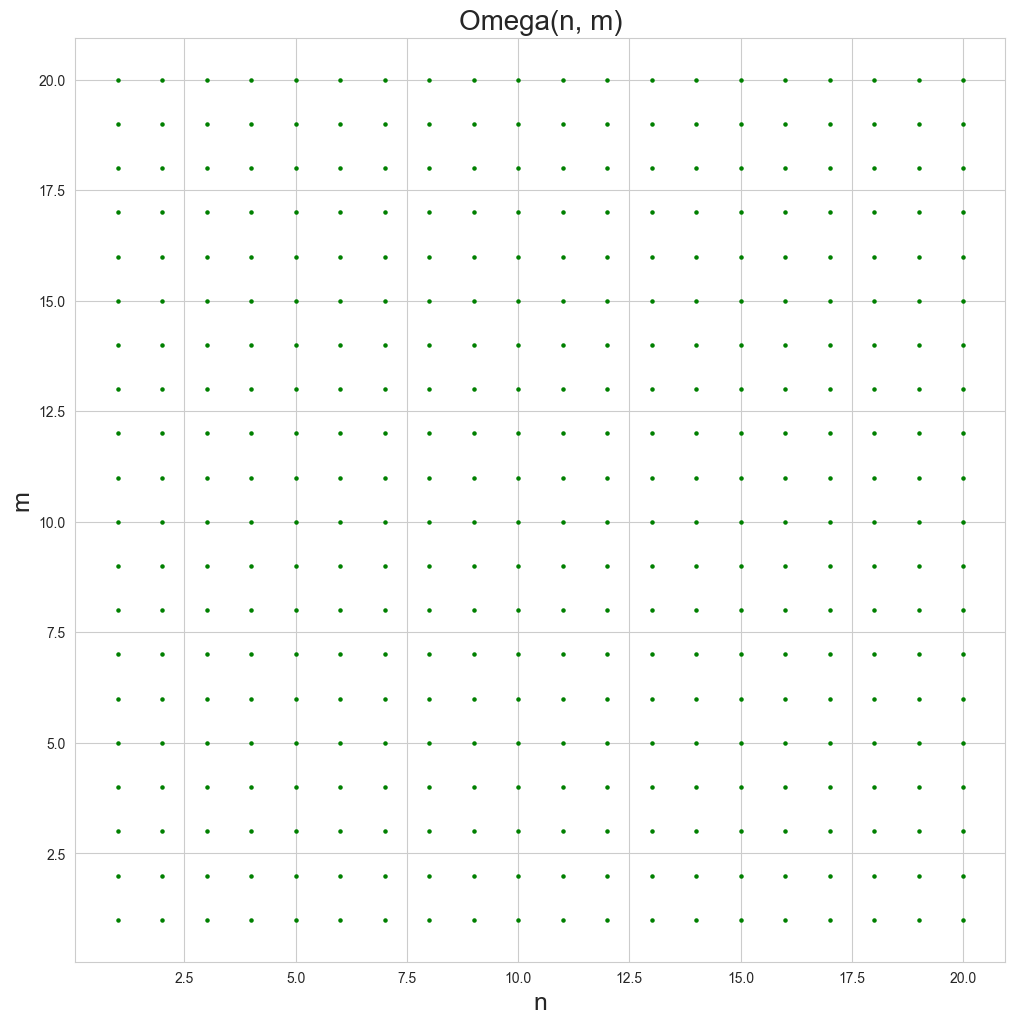

In [33]:
plt.figure(figsize=(12, 12))

green_dots_0 = np.array(green_dots_0)
green_dots_1 = np.array(green_dots_1)
green_dots_2 = np.array(green_dots_2)

red_dots_0 = np.array(red_dots_0)
red_dots_1 = np.array(red_dots_1)
red_dots_2 = np.array(red_dots_2)

# plt.scatter(green_dots_0[:,0], green_dots_0[:,1], s=5, c='green',)
plt.scatter(green_dots_1[:,0], green_dots_1[:,1], s=5, c='green',)
# plt.scatter(green_dots_2[:,0], green_dots_2[:,1], s=5, c='green',)

# plt.scatter(red_dots_0[:,0], red_dots_0[:,1], s=5, c='red',)
# plt.scatter(red_dots_1[:,0], red_dots_1[:,1], s=5, c='red',)
# plt.scatter(red_dots_2[:,0], red_dots_2[:,1], s=5, c='red',)

plt.xlabel("n", fontsize=18)
plt.ylabel("m", fontsize=18)
plt.title("Omega(n, m)", fontsize=20)
plt.show()